In [4]:
#Imports

from marketsai.markets.diff_demand import DiffDemandDiscrete

#import ray

from ray import tune, shutdown, init
from ray.tune.registry import register_env
from ray.rllib.agents.a3c.a2c import A2CTrainer
from ray.rllib.agents.dqn.dqn import DQNTrainer
from ray.tune.integration.mlflow import MLflowLoggerCallback
from ray.rllib.utils.schedules.exponential_schedule import ExponentialSchedule

import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# STEP 0: Inititialize ray

NUM_CPUS = 14
shutdown()
init(num_cpus=NUM_CPUS)

2021-04-04 18:35:03,834	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.202',
 'raylet_ip_address': '192.168.1.202',
 'redis_address': '192.168.1.202:26803',
 'object_store_address': '/tmp/ray/session_2021-04-04_18-35-03_004893_15061/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-04_18-35-03_004893_15061/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-04_18-35-03_004893_15061',
 'metrics_export_port': 64663,
 'node_id': '7a95bfb788876aa4d6d10db625809f835435e46c4bc86d74b74131db'}

In [6]:
# STEP 1: register environment

register_env("diffdemanddiscrete", DiffDemandDiscrete)
env = DiffDemandDiscrete()
policy_ids = ["policy_{}".format(i) for i in range(env.n_agents)]

In [7]:
# STEP 2: Experiment configuration

MAX_STEPS = 5 * 1000
PRICE_BAND_WIDE = 0.1
LOWER_PRICE = 1.47 - PRICE_BAND_WIDE
HIGHER_PRICE = 1.93 + PRICE_BAND_WIDE
DEC_RATE = math.e ** (-4 * 10 ** (-6))
DEC_RATE_HIGH = math.e ** (-4 * 10 ** (-6) * 4)

env_config = {
    "LOWER_PRICE": [LOWER_PRICE for i in range(env.n_agents)],
    "HIGHER_PRICE": [HIGHER_PRICE for i in range(env.n_agents)],
}
exploration_config = {
    "type": "EpsilonGreedy",
    "epsilon_schedule": ExponentialSchedule(
        schedule_timesteps=1,
        framework=None,
        initial_p=1,
        decay_rate=DEC_RATE,
    ),
}

config = {
    "gamma": 0.95,
    "lr": 0.15,
    "env": "diffdemanddiscrete",
    "exploration_config": exploration_config,
    "env_config": env_config,
    "horizon": 100,
    "soft_horizon": True,
    "no_done_at_end": True,
    "multiagent": {
        "policies": {
            policy_ids[i]: (
                None,
                env.observation_space["agent_{}".format(i)],
                env.action_space["agent_{}".format(i)],
                {},
            )
            for i in range(env.n_agents)
        },
        "policy_mapping_fn": (lambda agent_id: policy_ids[int(agent_id.split("_")[1])]),
    },
    "framework": "torch",
    "num_workers": NUM_CPUS - 1,
    "num_gpus": 0,
}

stop = {"info/num_steps_trained": MAX_STEPS}

In [8]:
#Step 3: Experiments

exp_name = "DQN_base_April4"
results = tune.run(
    "DQN",
    name=exp_name,
    config=config,
    checkpoint_freq=250,
    checkpoint_at_end=True,
    stop=stop,
    metric="episode_reward_mean",
    mode="max",
    callbacks=[MLflowLoggerCallback(experiment_name=exp_name, save_artifact=True)],
)

best_checkpoint = results.best_checkpoint
print("Best checkpont:", best_checkpoint)

Trial name,status,loc
DQN_diffdemanddiscrete_0c5ed_00000,RUNNING,


ary/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=15322)   warnings.warn(msg)
(pid=15334) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15334) Instructions for updating:
(pid=15334) non-resource variables are not supported in the long term
(pid=15331) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecate

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_diffdemanddiscrete_0c5ed_00000,RUNNING,192.168.1.202:15333,1,0.811421,1040,nan,nan,nan,nan


Result for DQN_diffdemanddiscrete_0c5ed_00000:
  custom_metrics: {}
  date: 2021-04-04_18-35-40
  done: false
  episode_len_mean: 100.0
  episode_reward_max: 37.228470471503925
  episode_reward_mean: 33.27907071907717
  episode_reward_min: 29.793132257240476
  episodes_this_iter: 0
  episodes_total: 52
  experiment_id: 1096c1c854c540819626dfac178b932f
  hostname: Matiass-MBP.fios-router.home
  info:
    last_target_update_ts: 6240
    learner:
      policy_0:
        allreduce_latency: 0.0
        cur_lr: 0.15
        grad_gnorm: 0.0025715355295687914
        max_q: 4.119324207305908
        mean_q: 3.9716761112213135
        mean_td_error: 0.01342056691646576
        min_q: 3.832009792327881
      policy_1:
        allreduce_latency: 0.0
        cur_lr: 0.15
        grad_gnorm: 0.011083835735917091
        max_q: 4.694247245788574
        mean_q: 4.6029205322265625
        mean_td_error: 0.09053413569927216
        min_q: 4.418233394622803
    num_steps_sampled: 6240
    num_steps_tra

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_diffdemanddiscrete_0c5ed_00000,RUNNING,192.168.1.202:15333,6,6.86501,6240,33.2791,37.2285,29.7931,100


Result for DQN_diffdemanddiscrete_0c5ed_00000:
  custom_metrics: {}
  date: 2021-04-04_18-35-43
  done: true
  episode_len_mean: 100.0
  episode_reward_max: 37.228470471503925
  episode_reward_mean: 33.41872296346883
  episode_reward_min: 29.793132257240476
  episodes_this_iter: 13
  episodes_total: 91
  experiment_id: 1096c1c854c540819626dfac178b932f
  hostname: Matiass-MBP.fios-router.home
  info:
    last_target_update_ts: 9360
    learner:
      policy_0:
        allreduce_latency: 0.0
        cur_lr: 0.15
        grad_gnorm: 0.003917689435184002
        max_q: 4.588627338409424
        mean_q: 4.4960222244262695
        mean_td_error: -0.028660133481025696
        min_q: 4.346267223358154
      policy_1:
        allreduce_latency: 0.0
        cur_lr: 0.15
        grad_gnorm: 0.0035966637078672647
        max_q: 4.836051940917969
        mean_q: 4.744014739990234
        mean_td_error: 0.019629180431365967
        min_q: 4.564702033996582
    num_steps_sampled: 9360
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_diffdemanddiscrete_0c5ed_00000,TERMINATED,,9,10.6235,9360,33.4187,37.2285,29.7931,100


2021-04-04 18:35:44,207	INFO tune.py:450 -- Total run time: 19.20 seconds (18.90 seconds for the tuning loop).
Best checkpont: /Users/matiascovarrubias/ray_results/DQN_base_April4/DQN_diffdemanddiscrete_0c5ed_00000_0_2021-04-04_18-35-25/checkpoint_9/checkpoint-9


ings.warn(msg)
(pid=15478) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=15478)   warnings.warn(msg)
(pid=15480) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=15480)   warnings.warn(msg)
(pid=15484) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(

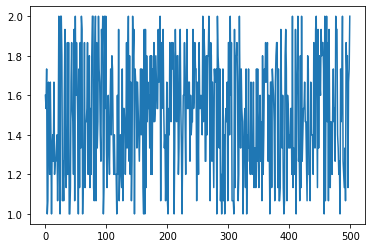

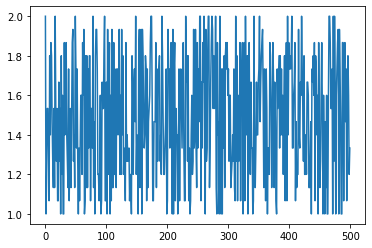

In [9]:
#Step 4: Evaluation

config["evaluation_config"] = {"explore": False}
trained_trainer = DQNTrainer(config=config)
trained_trainer.restore(best_checkpoint)
price_agent0_list = []
reward_agent0_list = []
price_agent1_list = []
reward_agent1_list = []
obs, reward, done, info = env.step({"agent_0": 1, "agent_1": 11})
for i in range(500):

    action_agent0 = trained_trainer.compute_action(obs["agent_0"], policy_id="policy_0")
    action_agent1 = trained_trainer.compute_action(obs["agent_1"], policy_id="policy_1")
    obs, reward, done, info = env.step(
        {"agent_0": action_agent0, "agent_1": action_agent1}
    )
    price_agent0_list.append(info["agent_0"])
    reward_agent0_list.append(reward["agent_0"])
    price_agent1_list.append(info["agent_1"])
    reward_agent1_list.append(reward["agent_1"])

plt.ion()

plt.plot(price_agent0_list)
plt.show()
plt.plot(price_agent1_list)
plt.show()

IRresults = {
    "Profits Agent 0": reward_agent0_list,
    "Profits Agent 1": reward_agent1_list,
    "Price Agent 0": price_agent0_list,
    "Price Agent 1": price_agent1_list,
}
df_IR = pd.DataFrame(IRresults)
df_IR.to_csv("collusion_IR_DQN.csv")